In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = coo_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15751, 411975)


In [3]:
# Define the number of components for SVD (adjust based on your application)
n_components = 1000  # This is a hyperparameter; change it to suit your needs

# Initialize and fit TruncatedSVD
svd = TruncatedSVD(n_components=n_components)
features=svd.fit_transform(sparse_matrix)

In [3]:
import sklearn.metrics
cosine_sim =sklearn.metrics.pairwise.cosine_distances(sparse_matrix)

In [11]:
# Set the diagonal to a high value to exclude it from the minimum search
np.fill_diagonal(cosine_sim, np.inf)

# Find the index of the minimum value
min_index = np.unravel_index(np.argmin(cosine_sim), cosine_sim.shape)
print("Index of minimum value (excluding diagonal):", min_index)

Index of minimum value (excluding diagonal): (np.int64(9560), np.int64(10124))


In [8]:
# You need to install HDBSCAN first: pip install hdbscan
import hdbscan

# Example with a minimum cluster size parameter
hdb = hdbscan.HDBSCAN(min_cluster_size=20,min_samples=1,max_cluster_size=1000)
clusters = hdb.fit_predict(cosine_sim)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
from sklearn.cluster import AgglomerativeClustering

# Example using complete linkage
agglo = AgglomerativeClustering(n_clusters=50, linkage='complete')
clusters = agglo.fit_predict(features)

In [4]:
from sklearn.cluster import KMeans
k = 10  # Set the number of clusters; you can use techniques like the elbow method to choose k
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(cosine_sim)

In [ ]:
from sklearn.cluster import DBSCAN

# Adjust eps (the neighborhood radius) and min_samples (minimum neighbors to form a dense region) as needed
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(sparse_matrix)

In [ ]:
import umap.umap_ as UMAP
import matplotlib.pyplot as plt

umapResult = UMAP.UMAP(n_components=2,metric='precomputed')
latent_2d = umapResult.fit_transform(cosine_sim )

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


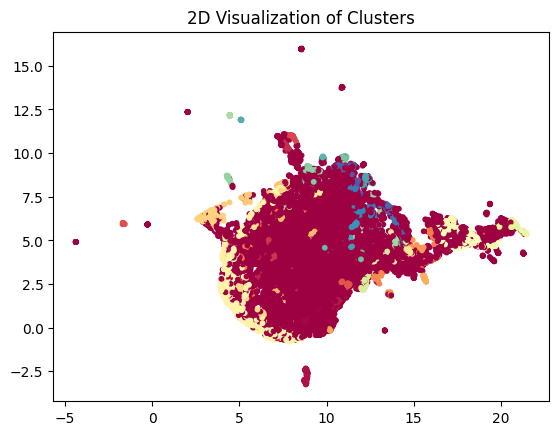

In [9]:
import umap.umap_ as UMAP
import matplotlib.pyplot as plt

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap='Spectral', s=10)
plt.title("2D Visualization of Clusters")
plt.show()